In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, scipy.stats as stats, torch

## format data

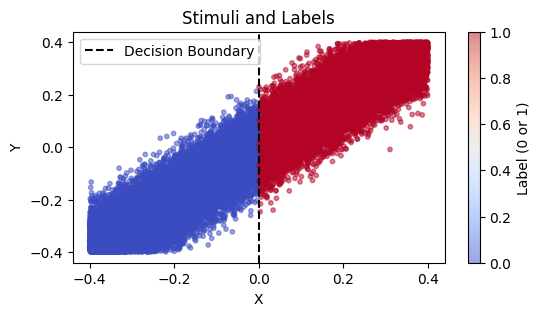

In [15]:
# Set random seeds for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

div_pos = .0

N = 50000
stim_pos = np.random.uniform(-.4, .4, N)
noise_std = .05

# Prepare truncated-normal parameters per sample
a = (-0.4 - stim_pos) / noise_std
b = ( 0.4 - stim_pos) / noise_std

# noise via truncated normal (always stays within [-0.4, 0.4])
X_np = stats.truncnorm(a, b, loc=stim_pos, scale=noise_std).rvs(size=N)
Y_np = stats.truncnorm(a, b, loc=stim_pos, scale=noise_std).rvs(size=N)

# true binary labels
labels_np = (X_np > 0).astype(float)

# convert to PyTorch tensors
X      = torch.from_numpy(X_np).float().unsqueeze(1)      # shape (N,1)
Y      = torch.from_numpy(Y_np).float().unsqueeze(1)
labels = torch.from_numpy(labels_np).float().unsqueeze(1)

# plot stimuli and labels
plt.figure(figsize=(6, 3))
plt.scatter(X_np, Y_np, c=labels_np, cmap='coolwarm', alpha=0.5, s=10)
plt.axvline(x=div_pos, color='black', linestyle='--', label='Decision Boundary')
plt.title('Stimuli and Labels')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Label (0 or 1)')
plt.legend()
plt.show()

## setup model

In [57]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam

# Define the model architecture
class NoisyModel(nn.Module):
    def __init__(self, embedding_noise=0.1, production_noise=0.05):
        super().__init__()
        self.linear1 = nn.Linear(1, 16)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(16, 1)
        self.embedding_noise = embedding_noise
        self.production_noise = production_noise
        
    def forward(self, x):
        # First layer
        hidden = self.linear1(x)
        hidden = hidden + torch.randn_like(hidden) * self.embedding_noise
        hidden = self.relu(hidden)
        
        # Output layer
        output = self.linear2(hidden)
        output = output + torch.randn_like(output) * self.production_noise
        
        # Smooth constraint using tanh (no sharp boundaries)
        output = torch.tanh(output) * 0.4  # Maps to [-0.4, 0.4] smoothly
        return output

# Create noisy model
model = NoisyModel(embedding_noise=0.15, production_noise=0.1)


# Hyperparameters
divider_position = 0.0
boundary_width   = 0.1
learning_rate    = 1e-2
batch_size       = 128
num_epochs       = 50

# Prepare data loader
dataset    = TensorDataset(X, Y, labels)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Optimizer & history
optimizer = Adam(model.parameters(), lr=learning_rate)
history = {'mse': [], 'bce': [], 'total': [], 'accuracy': []}

## training

In [58]:
for epoch in range(num_epochs):
    epoch_mse      = 0.0
    epoch_bce      = 0.0
    epoch_accuracy = 0.0
    epoch_total    = 0.0

    for inputs, targets, class_labels in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)

        # Compute per-sample weight based on distance to divider
        distance_from_divider = torch.abs(inputs - divider_position)
        classification_weight = torch.exp(-distance_from_divider / boundary_width)
        classification_weight = .1

        # Per-sample losses
        per_sample_mse = (outputs - targets).pow(2)
        per_sample_bce = F.binary_cross_entropy_with_logits(
            outputs, class_labels, reduction='none'
        )

        # Combine losses with distance-based weighting
        batch_loss = ((1 - classification_weight) * per_sample_mse
                      + classification_weight * per_sample_bce).mean()
        batch_loss.backward()
        optimizer.step()

        # Accumulate for logging
        epoch_mse      += per_sample_mse.mean().item()
        epoch_bce      += per_sample_bce.mean().item()
        epoch_total    += batch_loss.item()
        epoch_accuracy += (
            outputs.sigmoid().gt(0.5) == class_labels
        ).float().mean().item()

    num_batches = len(data_loader)
    history['mse'].append(epoch_mse / num_batches)
    history['bce'].append(epoch_bce / num_batches)
    history['total'].append(epoch_total / num_batches)
    history['accuracy'].append(epoch_accuracy / num_batches)

# Final predictions on the full dataset
with torch.no_grad():
    final_outputs      = model(X)
    y_predictions      = final_outputs.squeeze().numpy()
    class_predictions  = (final_outputs.sigmoid().squeeze().numpy() > 0.5).astype(int)


## collate data

In [59]:
df = pd.DataFrame({
    'X':            X_np[:1000],
    'Y_true':      Y_np[:1000],
    'Y_pred':      y_predictions[:1000],
    'class_pred':  class_predictions[:1000],
    'class_true':  labels_np[:1000].astype(int),
})
print(df.head())

          X    Y_true    Y_pred  class_pred  class_true
0  0.013924  0.043475  0.091575           1           1
1  0.095244  0.237398  0.134841           1           1
2  0.196361  0.082511  0.234421           1           1
3  0.064914 -0.027924  0.104900           1           1
4 -0.026151 -0.057617 -0.039110           0           0


## plot loss curves

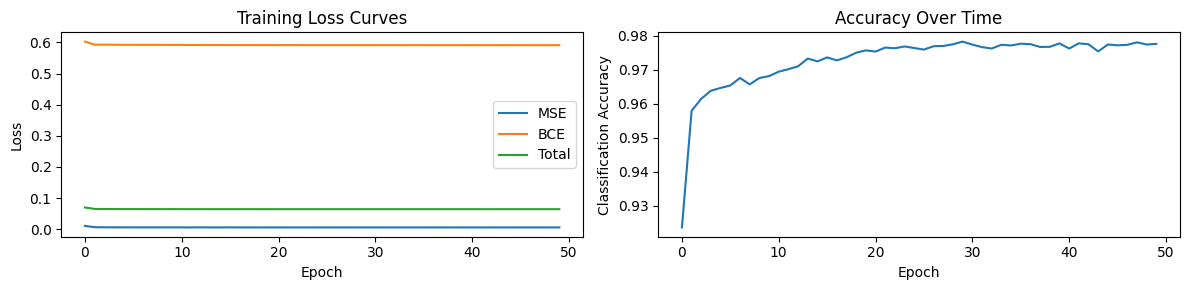

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

axs[0].plot(history['mse'], label='MSE')
axs[0].plot(history['bce'], label='BCE')
axs[0].plot(history['total'], label='Total')
axs[0].legend()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss Curves')

axs[1].plot(history['accuracy'], label='Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Classification Accuracy')
axs[1].set_title('Accuracy Over Time')

plt.tight_layout()
plt.show()


## viz behavior

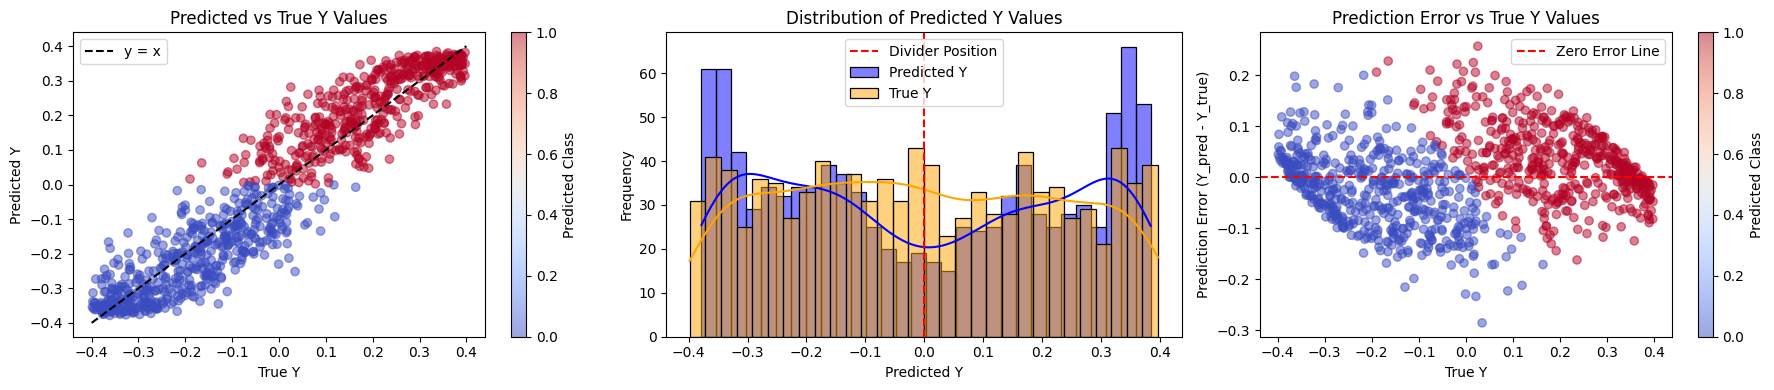

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# y_pred vs y_true
sc1 = axs[0].scatter(df['Y_true'], df['Y_pred'], c=df['class_pred'], cmap='coolwarm', alpha=0.5)
axs[0].plot([-0.4, 0.4], [-0.4, 0.4], 'k--', label='y = x')
axs[0].set_xlabel('True Y')
axs[0].set_ylabel('Predicted Y')
axs[0].set_title('Predicted vs True Y Values')
fig.colorbar(sc1, ax=axs[0], label='Predicted Class')
axs[0].legend()

# dist of y_pred
sns.histplot(df['Y_pred'], bins=30, kde=True, color='blue', label='Predicted Y', ax=axs[1])
sns.histplot(df['Y_true'], bins=30, kde=True, color='orange', label='True Y', ax=axs[1], alpha=0.5)
axs[1].axvline(x=0, color='red', linestyle='--', label='Divider Position')
axs[1].set_xlabel('Predicted Y')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Predicted Y Values')
axs[1].legend()

# y_pred - y_true vs y_true
sc2 = axs[2].scatter(df['Y_true'], df['Y_pred'] - df['Y_true'], c=df['class_pred'], cmap='coolwarm', alpha=0.5)
axs[2].axhline(y=0, color='red', linestyle='--', label='Zero Error Line')
axs[2].set_xlabel('True Y')
axs[2].set_ylabel('Prediction Error (Y_pred - Y_true)')
axs[2].set_title('Prediction Error vs True Y Values')
fig.colorbar(sc2, ax=axs[2], label='Predicted Class')
axs[2].legend()

plt.tight_layout()
plt.show()

## viz embeddings

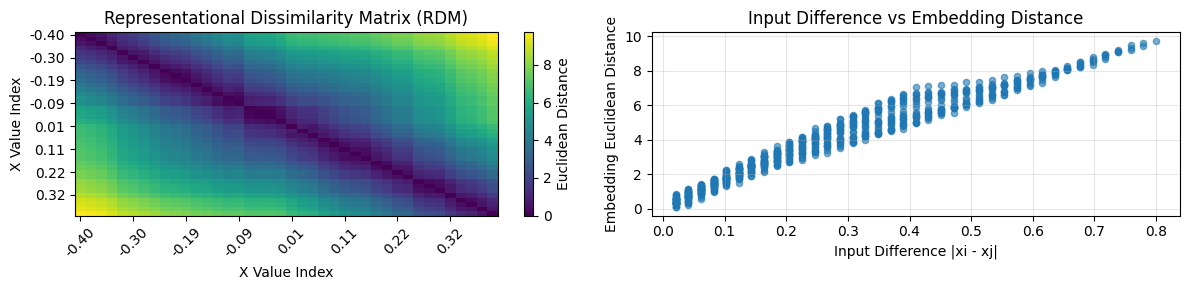

Embedding shape: (40, 16)
RDM shape: (40, 40)
X value range: [-0.400, 0.400]
Input difference range: [0.021, 0.800]
Embedding distance range: [0.101, 9.734]


In [62]:
# Extract embeddings from the hidden layer
def get_embeddings(model, x_vals):
    """Extract hidden layer representations (embeddings) from the model."""
    model.eval()
    embeddings = []
    
    with torch.no_grad():
        for x in x_vals:
            x_tensor = torch.tensor([[x]], dtype=torch.float32)
            # Get output from first layer and apply ReLU
            hidden = model.linear1(x_tensor)  # First linear layer
            # Add the embedding noise (to match training behavior)
            hidden = hidden + torch.randn_like(hidden) * model.embedding_noise
            hidden = model.relu(hidden)       # ReLU activation
            embeddings.append(hidden.squeeze().numpy())
    
    return np.array(embeddings)

# Sample 40 evenly spaced X values across the range
x_min, x_max = X_np.min(), X_np.max()
x_test = np.linspace(x_min, x_max, 40)

# Get embeddings for these X values
embeddings = get_embeddings(model, x_test)

# Compute pairwise Euclidean distances (RDM)
from scipy.spatial.distance import pdist, squareform
distances = pdist(embeddings, metric='euclidean')
rdm = squareform(distances)

# Compute input differences for scatter plot
input_diffs = []
embed_dists = []
for i in range(len(x_test)):
    for j in range(i+1, len(x_test)):
        input_diffs.append(abs(x_test[i] - x_test[j]))
        embed_dists.append(rdm[i, j])

# Plot the RDM and additional analysis
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# RDM heatmap
im = axs[0].imshow(rdm, cmap='viridis', aspect='auto')
axs[0].set_title('Representational Dissimilarity Matrix (RDM)')
axs[0].set_xlabel('X Value Index')
axs[0].set_ylabel('X Value Index')
fig.colorbar(im, ax=axs[0], label='Euclidean Distance')

# Add tick labels showing actual X values (every 5th value for readability)
tick_indices = np.arange(0, 40, 5)
tick_labels = [f'{x_test[i]:.2f}' for i in tick_indices]
axs[0].set_xticks(tick_indices)
axs[0].set_yticks(tick_indices)
axs[0].set_xticklabels(tick_labels, rotation=45)
axs[0].set_yticklabels(tick_labels)

# Plot input difference vs embedding distance
axs[1].scatter(input_diffs, embed_dists, alpha=0.6, s=20)
axs[1].set_xlabel('Input Difference |xi - xj|')
axs[1].set_ylabel('Embedding Euclidean Distance')
axs[1].set_title('Input Difference vs Embedding Distance')
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Embedding shape: {embeddings.shape}")
print(f"RDM shape: {rdm.shape}")
print(f"X value range: [{x_min:.3f}, {x_max:.3f}]")
print(f"Input difference range: [{min(input_diffs):.3f}, {max(input_diffs):.3f}]")
print(f"Embedding distance range: [{min(embed_dists):.3f}, {max(embed_dists):.3f}]")

## scratch

In [ ]:
stim = np.random.uniform(-0.38, 0.38, 50000)
x = np.sort(stim)

In [ ]:
N = 50_000
n = np.arange(N)

# Hann window runs 0→1→0 smoothly
hann = 0.5 * (1 - np.cos(2 * np.pi * n / (N - 1)))

# scale peak to 0.4
vals = 0.4 * hann
noise = vals

In [ ]:
y = x + noise

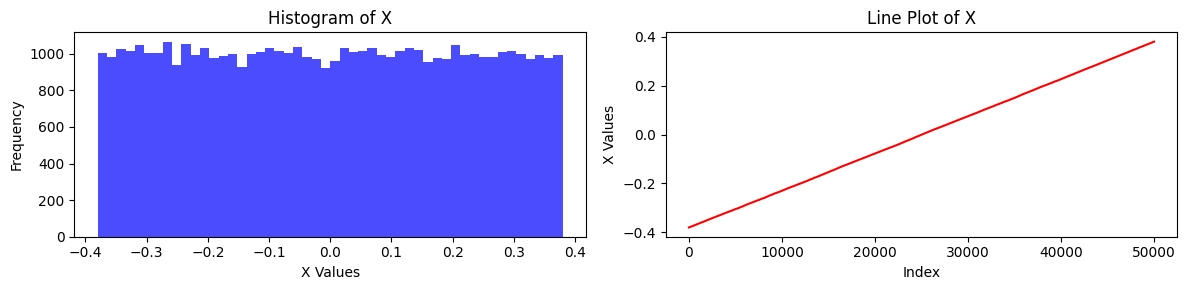

In [ ]:
# subplot in 1 row hist and plt.plot of X
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].hist(x, bins=50, color='blue', alpha=0.7)
axs[0].set_title('Histogram of X')
axs[0].set_xlabel('X Values')
axs[0].set_ylabel('Frequency')

axs[1].plot(x, color='red')
axs[1].set_title('Line Plot of X')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('X Values')   
plt.tight_layout()
plt.show()

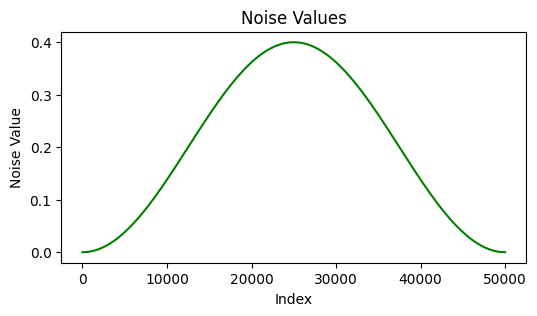

In [ ]:
# plot the noise
plt.figure(figsize=(6, 3))
plt.plot(noise, color='green')
plt.title('Noise Values')
plt.xlabel('Index')
plt.ylabel('Noise Value')
plt.show()

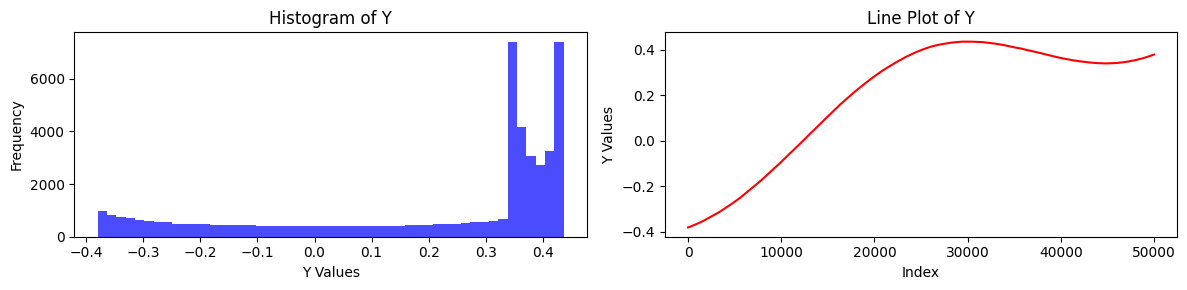

In [ ]:
# plot in 1 line using subplot the dist of y and y itself
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].hist(y, bins=50, color='blue', alpha=0.7)
axs[0].set_title('Histogram of Y')
axs[0].set_xlabel('Y Values')
axs[0].set_ylabel('Frequency')

axs[1].plot(y, color='red')
axs[1].set_title('Line Plot of Y')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Y Values')
plt.tight_layout()
plt.show()